<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/code/01ZLMA_ex03_statistical_inference_student_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 03
Exercise 03 of the course 01ZLMA.

## Contents

* Statistical Inference
 ---
* Testing
 ---




#  Necessary theory recap from Lecture 04

Under the conditions of regularity holds

1.  $ \ U(\beta) \sim N_{p}(0,I(\beta)) \Rightarrow  I^{-\frac{1}{2}}(\beta)\, U(\beta) {\stackrel{D}{\longrightarrow}} N_{p}(0, 1)$
2. $ U(\beta)I^{-1}(\beta)U(\beta)\sim \chi^{2}(p) \Rightarrow U(\beta)^T I^{-1}(\beta)U(\beta)  {\stackrel{D}{\longrightarrow}} \chi^{2}(p)$
3. Consistency of $\hat{\beta}$ and Wald statistics: \\
 $\hat{\beta}\sim N_{p}(\beta,I^{-1}(\beta)) \Rightarrow
(\hat{\beta}-\beta)^T I(\beta)(\hat{\beta}-\beta) {\stackrel{D}{\longrightarrow}} \chi^{2}(p)$



Saturated and null model

* Null model: $\mu_i = \mu, \forall i \in \{1, \ldots , n\}$ \\
The Null Model assumes one parameter for all of the data points, which means you only estimate 1 parameter.
* Saturated model: $Y_i = \hat{\mu_i}, \forall i \in \{1, \ldots , n\}$ \\
The Saturated Model is a model that assumes each data point has its own parameters, which means you have n parameters to estimate.
* Proposed Model:  model, where you try to explain your data points with $p$ parameters + an intercept term, so you have p+1 parameters, where $1 \leq p \leq n$.

Questions:
* What is the difference between null and saturated model?
* Which model has greater log-likelihoood value?
* Which model has the highest log-likelihood value?
* What can you say about asymptotic distributions of $\hat{\beta}$ and $U(\hat{\beta})$ for saturated model?

# Download custom library from GitHub
(using `wget` library)

In [1]:
# Please note that this cell works may not work in other env-s that Google Colab
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/code/helpers.py"
wget.download(url, '../content/helpers.py')  # path where Colab can find libraries

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6e7ce0140ea447ecc3a9ffeb96a00fb3d652a021b0ed737f5e699b76f840b25c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


'../content/helpers.py'

## Let's code

In [2]:
import numpy as np
import scipy
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import abline_plot

import pandas as pd

from helpers import DiagnosticPlots, Anova

sns.set_theme()

## Exercise 1: IWLS for Poisson Regression from the last week

Generate synthetic data from a Poisson generalized linear model (GLM) using a canonical **log link**.

- Set number of observations: $N = n*m=40$, $n = 1,\ldots,20$ , $m=2$
- Design matrix:
$$
X = \begin{bmatrix}
1 & \log(x_{2,1}) \\
1 & \log(x_{2,2}) \\
\vdots & \vdots \\
1 & \log(x_{2,n})
\end{bmatrix},\quad x_{2,i}=i
$$
- Choose regression coefficients:
$$
\beta = \begin{bmatrix} 0.5 \\ 1.2 \end{bmatrix}
$$

Generate response variable $Y$ from:
$$
\lambda_i = e^{X_i\beta}, \quad Y_i \sim \text{Poisson}(\lambda_i)
$$


- Manually implement the IWLS algorithm in Python (or R):

  - Derive and Compute weights ($W$).
  - Derive and Calculate adjusted response ($Z$).
  - Derive and Write IWLS
  - Update regression coefficients iteratively until convergence.
  - Compare your IWLS estimates with a standard GLM package
  -  discuss convergence, correctness, and interpretability of the results
---



---

###  Theoretical Derivation

Explicitly derive step-by-step:

**Step 1: Model and Link Function**
$$
Y_i \sim \text{Poisson}(\lambda_i), \quad i = 1,2,\dots,n \times m
$$


- Canonical link function:
$$
g(\lambda_i) = \log(\lambda_i) = X_i\beta = \beta_0 + \beta_1 \log(x_{2,i})
$$

 - The mean parameter:

$$
\lambda_i =  e^{X_i\beta} = e^{\beta_0}(x_{2,i})^{\beta_1}
$$


**Step 2: Log-Likelihood**
- The Poisson probability mass function for each observation $Y_i$:

$$
f(Y_i|\lambda_i) = \frac{\lambda_i^{Y_i} e^{-\lambda_i}}{Y_i!},\quad i=1,2,\dots,n\times m
$$
- Log-Likelihood
$$
\ell(\beta) = \sum_{i=1}^{n\times m} \left[ Y_i(X_i\beta) - e^{X_i\beta} - \log(Y_i!) \right]
$$

**Step 3: Score Function**

$$
U(\beta) = \frac{\partial \ell(\beta)}{\partial \beta} = X^T(Y - \mu), \quad \mu = e^{X\beta}
$$

**Step 4: Fisher Information Matrix**

$$
I(\beta) = X^T W X, \quad W = \text{diag}(\mu)
$$

**Step 5: IWLS Update Equations**

$$
\beta^{(t+1)} = \beta^{(t)} + \left[X^T W X\right]^{-1} X^T W (Z - X\beta^{(t)})
$$
with the adjusted response:
$$
Z = X\beta^{(t)} + \frac{Y - \mu}{\mu}
$$

Each iteration involves solving the weighted least squares equation:
$$
(X^T W X)\beta^{(t+1)} = X^T W Z
$$

---


### Solution
Solution based on Example 2 from the last Exercise 02

In [3]:
n  = 20 # n observations
m  = 2 # m parameters to estimate
X1 = np.ones((n*m,))  # Intercept
X2 = np.array([i for i in range(1, n+1)] * m) # Regressors
X = np.vstack([X1, np.log(X2)]).T # design matrix
beta = np.array([0.9, 1.3]) # Regression coefficients
lamdas = np.exp(X @ beta) # Means
Y = np.random.poisson(lamdas, n*m) # Response variable with Poisson distribution

d = pd.DataFrame(data={'Y': Y, 'X1': X1, 'X2':X2})
d.head()

,Y,X1,X2
0,2,1.0,1
1,8,1.0,2
2,14,1.0,3
3,12,1.0,4
4,22,1.0,5


In [4]:
model = smf.glm(formula='Y~np.log(X2)', data=d, family=sm.families.Poisson()).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -127.47
Date:                Wed, 26 Mar 2025   Deviance:                       35.180
Time:                        14:54:50   Pearson chi2:                     34.6
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9650      0.126      7.643      0.0

In [5]:
# standard api requires specifying endog (response) and exog (explanatory) design matrices
model = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -127.47
Date:                Wed, 26 Mar 2025   Deviance:                       35.180
Time:                        14:54:50   Pearson chi2:                     34.6
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9650      0.126      7.643      0.0

estimated params are:[0.96501564 1.28353756]
fitted values are:[  2.62482872   6.38975599  10.75236549  15.55491273  20.71358259
  26.17503815  31.90186275  37.86612674  44.04606018  50.42414296
  56.98592359  63.71924607  70.61372103  77.66035069  84.85125494
  92.17946629  99.63877304 107.22359716 114.9288977  122.75009321
   2.62482872   6.38975599  10.75236549  15.55491273  20.71358259
  26.17503815  31.90186275  37.86612674  44.04606018  50.42414296
  56.98592359  63.71924607  70.61372103  77.66035069  84.85125494
  92.17946629  99.63877304 107.22359716 114.9288977  122.75009321]


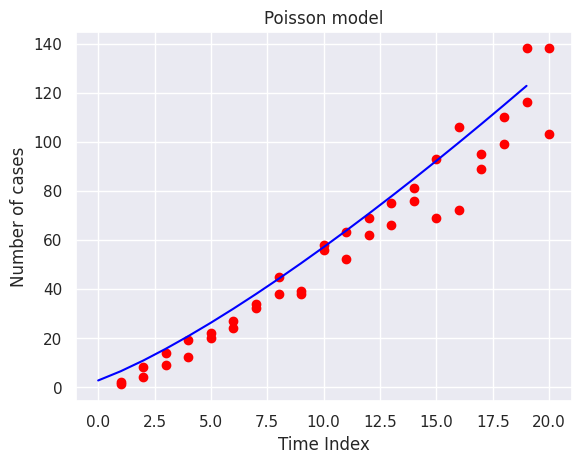

In [6]:
# Plot data
beta_e = model.params; print(f'estimated params are:{beta_e}')
y_hat = model.predict(); print(f'fitted values are:{y_hat}')

fig, ax = plt.subplots()
ax.scatter(X2, Y, color='red', marker='o')
ax.plot(np.unique(y_hat), color='blue')
ax.set_title('Poisson model')
ax.set_xlabel('Time Index')
ax.set_ylabel('Number of cases')
plt.show()

Repetition using custom function:

In [7]:
# function to calcualate weights W
def calc_W_inv(X, beta):
    return np.diag(np.exp(X @ beta))

In [8]:
# function to calcualate weights Z
def calc_Z(X,Y,beta):
    return X@beta + (Y - np.exp(X@beta)) / np.exp(X@beta)

In [9]:
# IWLS for example 2

def IWLS(X,Y,beta_init,maxiter,epsilon):
    res = {'FM': None, 'SV': None, 'betas': None}
    # Fisher-scoring algorithm
    i = 1     # first iteration

    beta_i = beta_init

    while i <= maxiter:
        W = calc_W_inv(X,beta_i)
        Z = calc_Z(X,Y,beta_i)
        beta_pred = beta_i
        beta_i = np.linalg.solve(X.T@W@X, X.T@W@Z)
        diff = np.max(np.abs(beta_i - beta_pred))
        if diff < epsilon:
            break
        W = calc_W_inv(X, beta_i)
        Z = calc_Z(X, Y, beta_i)

        res['SV'] = X.T@W@Z
        res['FM'] = X.T@W@X
        res['betas'] = np.linalg.solve(X.T@W@X, X.T@W@Z)
        i += 1
    return res

In [10]:
# Estimation of betas
result1 = IWLS(X,Y,np.ones(2),100,10^(-6))
print(f'Estimation of parameters: {result1["betas"]}')                # Estimation of parameters
print(f'Estimated Fisher information matrix: {result1["FM"]}')        # Estimated Fisher information matrix
print(f'Estimated covariance matrix: {np.linalg.inv(result1["FM"])}') # Estimated covariance matrix  = Inverse of estimated Fisher information matrix


Estimation of parameters: [0.96501564 1.28353756]
Estimated Fisher information matrix: [[ 2274.          5872.99525423]
 [ 5872.99525423 15598.33318279]]
Estimated covariance matrix: [[ 0.01594047 -0.00600182]
 [-0.00600182  0.00232388]]


Comparison of our custom solution with the built in glm function:

In [11]:
print(model.summary())
FIM1 = model.cov_params()
print(f'estimated covariance matrix {FIM1}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -127.47
Date:                Wed, 26 Mar 2025   Deviance:                       35.180
Time:                        14:54:51   Pearson chi2:                     34.6
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9650      0.126      7.643      0.0

In [12]:
# to find out what params has `model` object
for attr in dir(model):
    if not attr.startswith('_'):
        print(attr)

aic
bic
bic_deviance
bic_llf
bse
conf_int
converged
cov_kwds
cov_params
cov_type
deviance
df_model
df_resid
f_test
family
fit_history
fittedvalues
get_distribution
get_hat_matrix_diag
get_influence
get_margeff
get_prediction
info_criteria
initialize
k_constant
llf
llf_scaled
llnull
load
method
mle_settings
model
mu
nobs
normalized_cov_params
null
null_deviance
params
pearson_chi2
plot_added_variable
plot_ceres_residuals
plot_partial_residuals
predict
pseudo_rsquared
pvalues
remove_data
resid_anscombe
resid_anscombe_scaled
resid_anscombe_unscaled
resid_deviance
resid_pearson
resid_response
resid_working
save
scale
score_test
summary
summary2
t_test
t_test_pairwise
tvalues
use_t
wald_test
wald_test_terms


Asymptotics:

* $ (\hat{\beta} - \beta) \sim N_{p}(0, I^{-1}(\beta))$
* Estimated Fisher information matrix  $\hat{I}(\hat{\beta}) = (X^T \hat{W} X)$  matrix.
*  Estimated covariance matrix $\hat{V} (\hat{\beta}) = (X^T \hat{W} X)^{-1}$

In [13]:
n = 10
repet = 50
n_observ = np.array([1,2,5,10,100, 500])
betas_hat = np.zeros((6, repet, 2))

for _, i in enumerate(n_observ):
    for j in range(repet):
        X1 = np.ones((n*i,))
        X2 = np.array([i for i in range(1, n+1)]*i)
        X  = np.vstack([X1, np.log(X2)]).T
        beta = np.array([0.9, 1.3]) # Regression coefficients
        lamdas = np.exp(X @ beta) # Means
        Y = np.random.poisson(lamdas, n*i)
        betas_hat[_, j] = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit().params


In [14]:

for i in range(len(n_observ)):
    print(f"Number of observations: {n_observ[i]*n}")
    print(np.cov((betas_hat[i] - beta).T))
    print(np.mean(betas_hat[i] - beta))

Number of observations: 10
[[ 0.07040917 -0.03429395]
 [-0.03429395  0.01787946]]
-0.005336124105246742
Number of observations: 20
[[ 0.04163653 -0.0212119 ]
 [-0.0212119   0.01123608]]
-0.006574797332577313
Number of observations: 50
[[ 0.01686451 -0.00847907]
 [-0.00847907  0.00447916]]
0.001830079050464123
Number of observations: 100
[[ 0.00804067 -0.00410899]
 [-0.00410899  0.00220386]]
-0.0009499010912923267
Number of observations: 1000
[[ 0.00105883 -0.00053272]
 [-0.00053272  0.00027673]]
0.0014148052620109276
Number of observations: 5000
[[ 2.44596476e-04 -1.21740207e-04]
 [-1.21740207e-04  6.26107363e-05]]
-0.0005145677538186844


## Hypothesis testing

Use the model from the beginning again.

In [15]:
# Data generation
#np.random.seed(0)
#n = 30
#X1 = np.ones(n)
#X2 = np.log(np.arange(1, n + 1))
#X = np.column_stack([X1, X2])
#beta = np.array([0.5, 1.2])
#mu = np.exp(X @ beta)
#Y = np.random.poisson(mu)


In [16]:
# Data generation
n  = 20
m  = 2

X1 = np.ones((n*m,))
X2 = np.array([i for i in range(1, n+1)]*m)
X  = np.vstack([X1, np.log(X2)]).T
mu = np.exp(X @ beta)
beta = np.array([0.9, 1.3]) # Regression coefficients
lamdas = np.exp(X @ beta) # Means
Y = np.random.poisson(lamdas, n*m)


In [17]:
from scipy.stats import chi2


# Fit full and reduced models
model_full = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
X_reduced = X[:, [0]]
model_reduced = sm.GLM(Y, X_reduced, family=sm.families.Poisson()).fit()

# Wald test (individual parameters)
wald_stats = (model_full.params / model_full.bse)**2
wald_pvalues = chi2.sf(wald_stats, 1)

# Joint Wald test
wald_stat_joint = model_full.params.T @ np.linalg.inv(model_full.cov_params()) @ model_full.params
wald_pvalue_joint = chi2.sf(wald_stat_joint, len(model_full.params))

# Score test (omit X2 manually)
mu_reduced = model_reduced.mu
score_vector = X[:, 1].T @ (Y - mu_reduced)
I_reduced = (X[:, 1]**2 * mu_reduced).sum()
score_stat = (score_vector**2) / I_reduced
score_pvalue = chi2.sf(score_stat, 1)

# Deviances and LRT (manual)
deviance_full = model_full.deviance
deviance_reduced = model_reduced.deviance
lrt_stat = deviance_reduced - deviance_full
lrt_df = int(model_reduced.df_model - model_full.df_model)
lrt_pvalue = chi2.sf(lrt_stat, abs(lrt_df))

# Built-in tests
wald_test_sm = model_full.wald_test(np.eye(len(beta)), scalar=True)
score_test_sm = model_reduced.score_test(X[:, [1]])

# --- Results ---
print("Manual Computations:\n")
print(f"Wald test Intercept: Statistic = {wald_stats[0]:.4f}, p-value = {wald_pvalues[0]:.4f}")
print(f"Wald test X2: Statistic = {wald_stats[1]:.4f}, p-value = {wald_pvalues[1]:.4f}")

print(f"\nJoint Wald test: Statistic = {wald_stat_joint:.4f}, p-value = {wald_pvalue_joint:.4f}")

print(f"\nScore test (omit X2): Statistic = {score_stat:.4f}, p-value = {score_pvalue:.4f}")

print(f"\nDeviance (Full): {deviance_full:.4f}")
print(f"Deviance (Reduced): {deviance_reduced:.4f}")

print(f"\nLikelihood Ratio Test (omit X2): Statistic = {lrt_stat:.4f}, p-value = {lrt_pvalue:.4f}, df = {abs(lrt_df)}")

print("\nBuilt-in Tests from Statsmodels:\n")
print(f"Wald test (built-in): Statistic = {wald_test_sm.statistic:.4f}, p-value = {wald_test_sm.pvalue:.4f}")

# Correct handling of score_test_sm output
score_stat_sm_scalar = score_test_sm[0][0][0] if score_test_sm[0].size > 1 else score_test_sm[0].item()
score_pvalue_sm_scalar = score_test_sm[1].item()

print(f"\nScore test (built-in): Statistic = {score_stat_sm_scalar:.4f}, p-value = {score_pvalue_sm_scalar:.4f}")


Manual Computations:

Wald test Intercept: Statistic = 65.1681, p-value = 0.0000
Wald test X2: Statistic = 707.3823, p-value = 0.0000

Joint Wald test: Statistic = 42781.5459, p-value = 0.0000

Score test (omit X2): Statistic = 96.2943, p-value = 0.0000

Deviance (Full): 27.2445
Deviance (Reduced): 1109.9942

Likelihood Ratio Test (omit X2): Statistic = 1082.7497, p-value = 0.0000, df = 1

Built-in Tests from Statsmodels:

Wald test (built-in): Statistic = 42781.5459, p-value = 0.0000

Score test (built-in): Statistic = 783.9239, p-value = 0.0000


In [18]:
import numpy as np
import statsmodels.api as sm
from scipy.special import gammaln

# Log-likelihood manually (matching model.llf)
loglike_manual = np.sum(Y * np.log(model.mu) - model.mu - gammaln(Y + 1))
print("Manual Log-Likelihood:", loglike_manual)
print("Built-in Log-Likelihood:", model.llf)

# Pearson chi2 manually
pearson_chi2 = np.sum(((Y - model.mu)**2) / model.mu)
print("Manual Pearson chi2:", pearson_chi2)
print("Built-in Pearson chi2:", model.pearson_chi2)




Manual Log-Likelihood: -124.2587804985551
Built-in Log-Likelihood: -127.47081930162379
Manual Pearson chi2: 27.214314028549303
Built-in Pearson chi2: 34.562466754784225


In [19]:
model = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit()
print(model.summary())

# the unscaled (dispersion = 1) estimated covariance matrix of the estimated coefficients.
FIM1 = model.cov_params()
print(f'estimated covariance matrix {FIM1}')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.15
Date:                Wed, 26 Mar 2025   Deviance:                       27.244
Time:                        14:54:52   Pearson chi2:                     26.7
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0085      0.125      8.073      0.0

**Calculation** of Z value
 $$Z_i = \frac{\hat{\beta_i}}{(I^{-1}(\hat{\beta_i}))_{ii}}$$

In [20]:
# Testing statistics from summary table
print(model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.15
Date:                Wed, 26 Mar 2025   Deviance:                       27.244
Time:                        14:54:52   Pearson chi2:                     26.7
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0085      0.125      8.073      0.0

In [21]:
# By definition

z_stat = model.params / np.sqrt(np.diag(model.cov_params()))
print(z_stat)
z_stat == model.tvalues

[ 8.07267405 26.59665894]


array([ True,  True])

In [22]:
# p-values of the test
p_val = 2*scipy.stats.norm.sf(z_stat, loc=0, scale=1)
print(f'pval: {p_val}')
p_val == model.pvalues

pval: [6.87750307e-016 7.41982570e-156]


array([ True,  True])

In [23]:
### 100(1-alpha) confidence interval
alpha = 0.05
u = scipy.stats.norm.ppf(1-alpha/2,0,1)
CI_LB = model.params[1] - u * np.sqrt(np.diag(model.cov_params())[1])
CI_UB = model.params[1] + u * np.sqrt(np.diag(model.cov_params())[1])

print(f"2.5% CI = {CI_LB},ESTIM = {model.params[1]}, 97.5% CI = {CI_UB}")


# built in function
print(model.conf_int())

2.5% CI = 1.1761664154946478,ESTIM = 1.2697359392770873, 97.5% CI = 1.3633054630595267
[[0.7636668  1.2533872 ]
 [1.17616642 1.36330546]]


Question:

* Compare hypothesis testing in LM vs. GLM

## Comparison of inference in Linear Regression (LR) and Generalized Linear Models (GLM)

### Dimension notation:

- $n$: number of observations (rows in dataset)
- $p$: number of parameters (including intercept, columns in $X$)
- $q$: number of parameters tested simultaneously in multiple-parameter tests (difference between full and reduced model parameters)

---

### Hypothesis tests summary table

| Model Type       | Test type                      | Distribution         | Name(s) used       |
|------------------|--------------------------------|----------------------|--------------------|
| **Linear (OLS)** | Individual parameter           | $t_{n-p}$            | t-test             |
| **Linear (OLS)** | Multiple parameters            | $F_{q,n-p}$          | F-test (ANOVA)     |
| **GLM (MLE)**    | Individual parameter           | $N(0,1)$             | Wald test, z-test  |
| **GLM (MLE)**    | Multiple parameters (Wald)     | $\chi^2_q$           | Wald test          |
| **GLM (MLE)**    | Likelihood Ratio Test (nested) | $\chi^2_q$           | LRT, Chi-squared   |
| **GLM (MLE)**    | Score (Rao) test               | $\chi^2_q$           | Score test         |

---



## Comparison of inference in Linear Regression (LR) and Generalized Linear Models (GLM)

| Aspect                      | Linear Regression (LR)                                 | Generalized Linear Models (GLM)                           |
|-----------------------------|--------------------------------------------------------|------------------------------------------------------------|
| **Model specification**     | $$Y = X\beta + \varepsilon,\quad \varepsilon \sim N(0,\sigma^2 I)$$ | $$g(\mu) = X\beta,\quad Y\sim\text{Exponential family}$$  |
| **Estimator type**          | OLS (also MLE under normality)                         | MLE                                                        |
| **Variance estimation**     | Explicitly estimated: $$\hat{\sigma}^2 = \frac{\|Y - X\hat{\beta}\|^2}{n-p}$$ | Implicitly determined by mean-variance relationship (no separate parameter) |
| **Estimator distribution**  | Exact finite-sample: $$\frac{\hat{\beta}_j - \beta_j}{SE(\hat{\beta}_j)} \sim t_{n-p}$$ | Asymptotic (large-sample): $$\frac{\hat{\beta}_j - \beta_j}{SE(\hat{\beta}_j)} \xrightarrow{d} N(0,1)$$ |
| **Test for single parameter** | $$t = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)} \sim t_{n-p}$$ | Wald test (z-test): $$Z = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}\sim N(0,1)$$ |
| **Test for multiple parameters** | F-test: $$F = \frac{(RSS_0 - RSS_1)/q}{RSS_1/(n-p)}\sim F_{q,n-p}$$ | Likelihood Ratio or Wald test: $$\chi^2 = 2(l_{\text{full}}-l_{\text{reduced}})\sim\chi^2_q$$ |
| **Small sample inference**  | Exact (t and F-distributions)                          | Approximate (not exact, relies on large-sample assumptions) |
| **Large sample inference**  | t-distribution converges to normal (z-test)            | Normal (z-test, Wald test) approximation                   |

                              |

---



# Inference and Hypothesis Tests in GLM (statsmodels)

GLM inference typically relies on Maximum Likelihood Estimation (MLE) using iteratively reweighted least squares (IRLS).


### Wald Test
- **Formula:**
  $$
  W = (\hat{\beta} - \beta_0)^T [I(\hat{\beta_0})]^{-1} (\hat{\beta} - \beta_0)
  $$
- Evaluated using the covariance matrix (Hessian-based).
- Assumes large-sample normality of parameter estimates.

### Likelihood Ratio Test (LRT)
- **Formula:**
  $$
  LR = 2(l_{full} - l_{reduced})
  $$
- Compares log-likelihoods of nested models.
- More powerful if correctly specified; asymptotically follows $\chi^2$ distribution.

### Score (Rao) Test
- **Formula:**
  $$
  R = s(\hat{\beta_0})^T [I(\hat{\beta_0})]^{-1}s(\hat{\beta_0})
  $$
  - Where $s$ is the gradient (score function), and $I$ is Fisher information.
- Only requires the restricted model (does not fit the full model).
- Computationally efficient for large models.

## Deviance
- **Definition:**
  $$
  D = 2(l_{sat} - l_{model})
  $$
  - Measures discrepancy between fitted model and the saturated (fully parameterized) model.
- Used primarily to assess overall model fit, smaller deviance indicates better fit.



# Deviance

Deviance is a measure of goodness of fit of a GLM.


Log-likelihood of the saturated model is the highest possible one with given data, $\tilde{\mu}_i = y_i$ and $\tilde{\theta_i} = \theta(y) = (b')^{-1}(y_i)$.
$$l(\tilde{\mu},\phi;y)=\sum_{i=1}^{n}\frac{y_{i}\tilde{\theta}_{i}-b(\tilde{\theta}_{i})}{a_{i}(\phi)}+\sum_{i=1}^{n}c(y_i,\phi)$$

Scale deviance statistics:
$${S(y,\hat{\mu},\phi)}=2\left[l(\tilde{\mu},\phi;y)-l(\hat{\mu},\phi;y)\right]
=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}(\phi)}.
$$

Deviance:
Let $a_{i}(\phi)=a_{i}\phi$, then
$$S(y,\hat{\mu},\phi)=\frac{D(y,\hat{\mu})}{\phi},
$$
and
$$
D(y,\hat{\mu})=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}}
$$

### Comparison of two models

Assume model $D_0$ with $p_0$ paramters and its sub-model $D_1$ with $p_1$ parameters, then
$$ \frac{1}{\phi} (D_0 - D_1) \sim \chi_{(p_0 - p_1)} $$

Question:
* Can we take deviance as a measure of the model quality?
* Can we use deviance as a measure of the saturated model quality?
* Complete the sentence: Compare two GLMs with deviance is like compare two LMs with ...

In [24]:
# Add random variable to the previous model
Z = scipy.stats.uniform.rvs(loc=0, scale=1, size=n*m)
model_0 = sm.GLM(endog=Y, exog=np.hstack([X, Z[:, None]]), family=sm.families.Poisson()).fit()
print(model_0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       37
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.09
Date:                Wed, 26 Mar 2025   Deviance:                       27.127
Time:                        14:54:52   Pearson chi2:                     26.5
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9994      0.128      7.828      0.0

In [25]:
# Proposed model
m1 = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson())
model_1 = m1.fit()
print(model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.15
Date:                Wed, 26 Mar 2025   Deviance:                       27.244
Time:                        14:54:52   Pearson chi2:                     26.7
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0085      0.125      8.073      0.0

In [26]:
# Null model

model_n = sm.GLM(endog=Y, exog=X[:, 0], family=sm.families.Poisson()).fit()
print(model_n.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -665.52
Date:                Wed, 26 Mar 2025   Deviance:                       1110.0
Time:                        14:54:52   Pearson chi2:                     991.
No. Iterations:                     4   Pseudo R-squ. (CS):          5.662e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0483      0.021    193.812      0.0

In [27]:
# Saturated model CANNOT BY OBTAINED BY STATSMODELS BY DEFAULT 'CAUSE THEY PREVENT ZERO DIVISION

I = np.diag(np.ones((m*n,)))

model_s = sm.GLM(endog=Y, exog=I, family=sm.families.Poisson()).fit()
print(model_s.summary())
print(f'Residual deviance is: {model_s.deviance}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -110.52
Date:                Wed, 26 Mar 2025   Deviance:                   9.0372e-14
Time:                        14:54:52   Pearson chi2:                 9.41e-26
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6931      0.707      0.980      0.3

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


For Poisson model:
$$D = 2 \sum_{i=1}^n y_i log( \frac{y_i}{\hat{\mu_i}})$$

In [28]:
mu_est_0 = model_0.predict()
mu_est_1 = model_1.predict()

Dev_0 = 2*np.sum(Y*np.log(Y/mu_est_0))
print(Dev_0)
Dev_1 = 2*np.sum(Y*np.log(Y/mu_est_1))
print(Dev_1)


27.126799259095364
27.24445302177334


In [29]:
anova = Anova()
anova(model_1)

,resid_df,resid_deviance,df,deviance,chi2,p_val
x0,39,1109.994170,NaN,NaN,NaN,NaN
x1,38,27.244453,1.0,1082.749717,1082.749717,1.854224e-237


## Anova testing


In [30]:
display(anova(model_1))
display(anova(model_1, test = "Cp"))
display(anova(model_1, test = "Chisq"))

display(anova(model_1, model_0, test = "Rao"))
print(anova(model_1, model_0, test = "LRT"))


,resid_df,resid_deviance,df,deviance,chi2,p_val
x0,39,1109.994170,NaN,NaN,NaN,NaN
x1,38,27.244453,1.0,1082.749717,1082.749717,1.854224e-237


,resid_df,resid_deviance,df,deviance,cp
x0,39,1109.994170,NaN,NaN,1109.994170
x1,38,27.244453,1.0,1082.749717,29.244453


,resid_df,resid_deviance,df,deviance,chi2,p_val
x0,39,1109.994170,NaN,NaN,NaN,NaN
x1,38,27.244453,1.0,1082.749717,1082.749717,1.854224e-237


/content/helpers.py:169: UserWarning: Note that rao score statistic may be inccorect. Currently it is Generalized Pearson statistic
  warnings.warn("Note that rao score statistic may be inccorect. Currently it is Generalized Pearson statistic")


,resid_df,resid_deviance,df,deviance,rao,p_val
0,38,27.244453,NaN,NaN,NaN,NaN
1,37,27.126799,1.0,0.117654,0.109319,0.740921


   resid_df  resid_deviance   df  deviance      chi2     p_val
0        38       27.244453  NaN       NaN       NaN       NaN
1        37       27.126799  1.0  0.117654  0.117654  0.731593


In [31]:
# p-value of deviance tst
# H0: model fit data
p_dev = scipy.stats.chi2.sf(model_1.deviance, df=model_1.df_resid)

print(p_dev)

# critical value
C_val = scipy.stats.chi2.isf(0.05, model_1.df_resid)
print(C_val)

print(model_1.summary())

display(anova(model_1,model_s, test = "LRT"))   # saturated vs. final model



0.9024540548881987
53.38354062296933
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.15
Date:                Wed, 26 Mar 2025   Deviance:                       27.244
Time:                        14:54:52   Pearson chi2:                     26.7
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          

,resid_df,resid_deviance,df,deviance,chi2,p_val
0,38,2.724445e+01,NaN,NaN,NaN,NaN
1,0,8.881784e-14,38.0,27.244453,27.244453,0.902454


#### Rao score statistics (for Poisson GLM)


In [32]:
rao = np.sum((Y-model_1.predict())**2/model_1.predict())

print(f'rao score statistic: {rao}')
print(f'p-val of rao test: {scipy.stats.chi2.sf(rao, df=model_1.df_resid)}')

######  By saturated model

anova(model_1,model_s, test = "Rao")

rao score statistic: 26.653914632304183
p-val of rao test: 0.9163612297875362


/content/helpers.py:169: UserWarning: Note that rao score statistic may be inccorect. Currently it is Generalized Pearson statistic
  warnings.warn("Note that rao score statistic may be inccorect. Currently it is Generalized Pearson statistic")


,resid_df,resid_deviance,df,deviance,rao,p_val
0,38,2.724445e+01,NaN,NaN,NaN,NaN
1,0,8.881784e-14,38.0,27.244453,26.653915,0.916361


# Your turn:
1. Generate data with followings parameters
 * $Y \sim Poi(\mu_i)$, where $E[Y_i] = \mu_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} = x_i^T \beta \  \Rightarrow \ q(\mu_i) = \mu_i =  x_i^T \beta  = \eta_i$
* $X_{i1} \sim N(50,10)$
* $X_{i2} \sim U(10,60)$
* $X_{i3} \sim Ber(0.45)$
* $n = 40$
2. Compute $\hat{\mu_i}$  for saturated, null,"full","best" models.
3. Compute Deviance, Rao, Wald statistics for your model and compare final model with the saturated and "full" ones.
4. Generate 100x data for  $n \in \{20,40,60,80,100 \}$ and plot $(\hat{\beta_i} -\beta_i)$ vs. $(n)$


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [34]:
import scipy

def generate_data(n, beta):
    X1 = np.random.normal(50, 10, n)
    X2 = np.random.uniform(10, 60, n)
    X3 = np.random.binomial(1, 0.45, n)
    mu = beta[0] + beta[1]*X1 + beta[2]*X2 + beta[3]*X3
    Y = np.random.poisson(mu)
    return pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2, 'X3': X3})

def fit_models(data):
    models = {
        "Null Model": smf.glm("Y ~ 1", data=data, family=sm.families.Poisson()).fit(),
        "X1 Model": smf.glm("Y ~ 1 + X1", data=data, family=sm.families.Poisson()).fit(),
        "X2 Model": smf.glm("Y ~ 1 + X2", data=data, family=sm.families.Poisson()).fit(),
        "X1 + X2 Model": smf.glm("Y ~ 1 + X1 + X2", data=data, family=sm.families.Poisson()).fit(),
        "X1 + X3 Model": smf.glm("Y ~ 1 + X1 + X3", data=data, family=sm.families.Poisson()).fit(),
        "Full Model": smf.glm("Y ~ 1 + X1 + X2 + X3", data=data, family=sm.families.Poisson()).fit()
    }
    return models

def compute_mu(data, model):
    return np.exp(model.fittedvalues)

def compute_deviance(model, null_model):
    return null_model.deviance - model.deviance

def compute_rao_test(null_model, full_model):
    score = np.sum((null_model.predict() - full_model.predict())**2)
    fisher_info = np.linalg.inv(null_model.cov_params())
    rao_stat = score / fisher_info.trace()
    return rao_stat

def compute_wald_test(model):
    wald_stats = (model.params / model.bse) ** 2  # Wald test
    return wald_stats

def compute_aic(models):
    return {name: model.aic for name, model in models.items()}

def likelihood_ratio_test(model1, model2):
    lr_stat = 2 * (model2.llf - model1.llf)
    df = model2.df_model - model1.df_model
    p_value = 1 - scipy.stats.chi2.cdf(lr_stat, df)
    return lr_stat, p_value

def select_best_model(models):
    best_model_name = min(models, key=lambda name: models[name].aic)
    return best_model_name, models[best_model_name]


In [35]:
# Parameters
beta_true = [1, 2.0, 1.0, 3.0]

In [36]:
# Model fitting
data_sample = generate_data(40, beta_true)
models = fit_models(data_sample)
aic_values = compute_aic(models)

In [37]:
print(models["Null Model"].summary())
print(models["X1 Model"].summary())
print(models["X2 Model"].summary())
print(models["X1 + X2 Model"].summary())
print(models["X1 + X3 Model"].summary())
print(models["Full Model"].summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.00
Date:                Wed, 26 Mar 2025   Deviance:                       147.87
Time:                        14:54:52   Pearson chi2:                     151.
No. Iterations:                     4   Pseudo R-squ. (CS):         -2.842e-14
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9273      0.013    366.079      0.0

In [38]:
best_model_name, best_model = select_best_model(models)
print("AIC values:", aic_values)
print(f"Best model selected: {best_model_name}")

AIC values: {'Null Model': np.float64(419.99694665667823), 'X1 Model': np.float64(353.53664960221226), 'X2 Model': np.float64(364.5821647313044), 'X1 + X2 Model': np.float64(311.7396266090901), 'X1 + X3 Model': np.float64(346.5124364238808), 'Full Model': np.float64(311.71491338070916)}
Best model selected: Full Model


In [39]:
wald_x1x2 = compute_wald_test(models["X1 + X2 Model"])
print("Wald test for X1 + X2 Model:", wald_x1x2)
wald_full = compute_wald_test(models["Full Model"])
print("Wald test for Full Model:", wald_full)

Wald test for X1 + X2 Model: Intercept    2006.700498
X1             54.505294
X2             43.436404
dtype: float64
Wald test for Full Model: Intercept    2004.196944
X1             54.603377
X2             36.499282
X3              2.027416
dtype: float64


In [40]:
dev_full = compute_deviance(models["Full Model"], models["Null Model"])
print("Deviance for Full Model:", dev_full)
dev_x1x2 = compute_deviance(models["X1 + X2 Model"], models["Null Model"])
print("Deviance for X1 + X2 Model:", dev_x1x2)

Deviance for Full Model: 114.28203327597177
Deviance for X1 + X2 Model: 112.25732004759178


In [41]:
rao_full = compute_rao_test(models["Null Model"], models["Full Model"])
print("Rao score test for Full Model:", rao_full)
rao_x1x2 = compute_rao_test(models["Null Model"], models["X1 + X2 Model"])
print("Rao score test for X1 + X2 Model:", rao_x1x2)

Rao score test for Full Model: 2.9187271923336593
Rao score test for X1 + X2 Model: 2.8623429641311335


In [42]:
LRT_x1x2_vs_full = likelihood_ratio_test(models["X1 + X2 Model"], models["Full Model"])
print("Likelihood Ratio Test (Full vs. X1 + X2):", LRT_x1x2_vs_full)

Likelihood Ratio Test (Full vs. X1 + X2): (np.float64(2.0247132283809606), np.float64(0.154758135201425))


In [43]:
def estimate_bias(n_values, beta_true, iterations=100):
    bias_results_x1x2 = {i: [] for i in range(3)}
    bias_results_full = {i: [] for i in range(4)}

    for n in n_values:
        for _ in range(iterations):
            data = generate_data(n, beta_true)
            model_x1x2 = smf.glm("Y ~ X1 + X2", data=data, family=sm.families.Poisson()).fit()
            model_full = smf.glm("Y ~ X1 + X2 + X3", data=data, family=sm.families.Poisson()).fit()

            for i, b in enumerate(model_x1x2.params[:3]):  # Intercept, X1, and X2
                bias_results_x1x2[i].append(b - beta_true[i])

            for i, b in enumerate(model_full.params[:4]):  # Intercept, X1, X2, and X3
                bias_results_full[i].append(b - beta_true[i])

    return bias_results_x1x2, bias_results_full

def plot_bias(n_values, bias_results_x1x2, bias_results_full):
    plt.figure(figsize=(8,6))
    for i in range(3):
        plt.plot(n_values, [np.mean(bias_results_x1x2[i][j:j+100]) for j in range(0, len(bias_results_x1x2[i]), 100)], label=f'β_{i} (X1+X2)')
    for i in range(4):
        plt.plot(n_values, [np.mean(bias_results_full[i][j:j+100]) for j in range(0, len(bias_results_full[i]), 100)], linestyle='dashed', label=f'β_{i} (Full Model)')

    plt.axhline(0, linestyle='--', color='black')
    plt.xlabel("Sample size n")
    plt.ylabel("Bias (β_i - b_i)")
    plt.legend()
    plt.title("Bias of Estimated Coefficients vs. Sample Size for X1 + X2 and Full Model")
    plt.show()

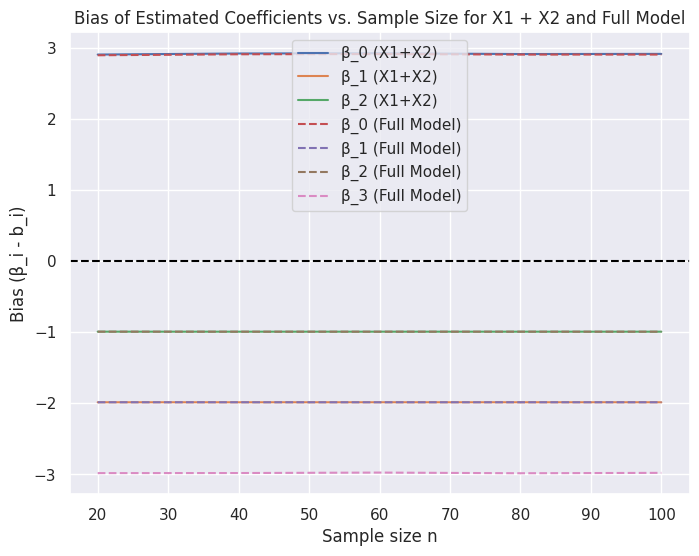

In [44]:
n_values = [20, 40, 60, 80, 100]
bias_results_x1x2, bias_results_full = estimate_bias(n_values, beta_true)
plot_bias(n_values, bias_results_x1x2, bias_results_full)

We picked model 1 + X1 + X2
